<a href="https://colab.research.google.com/github/ollihansen90/VanillaGAN/blob/main/VanillaGAN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VanillaGAN für MNIST

## Importiere Zeugs (nur ausführen)
In diesem Abschnitt werden die nötigen Packages und MNIST geladen.

60000
torch.Size([64, 1, 28, 28])
torch.Size([64])


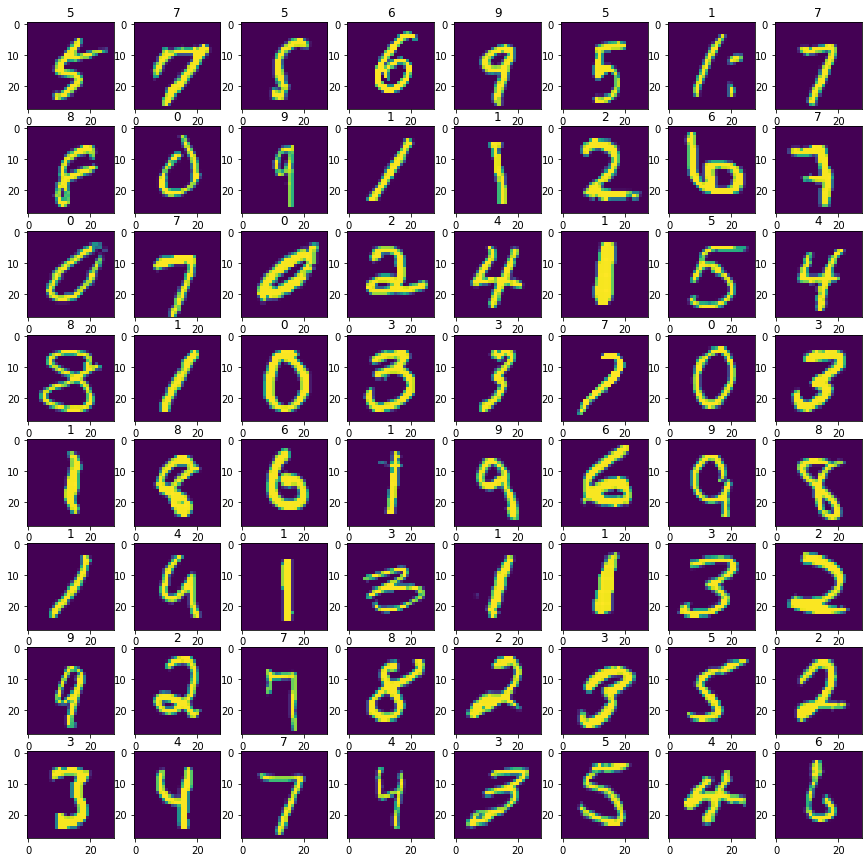

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as ds
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Normalize, Compose
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

MNIST = ds.MNIST(
            root="./data", 
            train=True, 
            download=True, 
            transform=Compose([
                               ToTensor(), # wandle in Torch-Tensor um
                               Normalize([0.5], [0.5]) # Normalisiere auf Mittelwert 0.5, STD 0.5
                               ])
            )
# Lade MNIST
dataloader = DataLoader(MNIST, batch_size=64, shuffle=True)
print(len(MNIST))

# Plotte Beispielbilder
batch, labels = next(iter(dataloader))
print(batch.shape)
print(labels.shape)

plt.figure(figsize=[15,15])
for i in range(64):
    plt.subplot(8,8,i+1)
    plt.imshow(batch[i].squeeze().detach().numpy())
    plt.title(labels[i].item())
plt.show()


## Netzwerke
Hier werden die Netzwerke erstellt. 
### Allgemein
Mit `nn.Linear(...)` können MLP-Layer erstellt werden (https://pytorch.org/docs/stable/generated/torch.nn.Linear.html). 

Statt ReLU als Aktivierungsfunktion ist LeakyReLU möglicherweise sinnvoller (https://pytorch.org/docs/stable/generated/torch.nn.functional.leaky_relu.html). Als `negative_slope` kann dabei ein recht großer Wert (z.B. 0.1) gewählt werden. 
### Generator
Die Eingabegröße für den Generator kann frei gewählt werden, allerdings sollte sie nicht zu klein (für ausreichend Variabilität) und nicht zu groß (unnötig viel Rechenaufwand) gesetzt werden. 128 ist schon ganz gut. 

Sinnvoll wären *drei oder vier Layer* mit steigender Hidden-Dimension. Zwischen jedem Linear-Layer sollte UNBEDINGT eine Aktivierungsfunktion (s.o.) eingefügt werden.

Die Ausgabe muss 784 groß sein, da sie die Eingabe für den Diskriminator ist.
### Diskriminator
Der Diskriminator sollte am besten das "Gegenteil" vom Generator sein. Sind die Dimensionen vom Generator also beispielsweise 128->256->512, sollte der Diskriminator 512->256->128 haben. Die Ausgabedimension sollte immer 1 sein (Wahrscheinlichkeit für "generiert" vs. "natürlich"). 

Die Eingabe des Diskriminators ist das vektorisierte MNIST-Bild, es ist also ein Vektor (oder ein Batch von Vektoren) der Länge `28^2=784`.

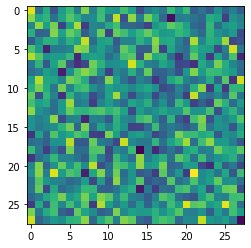

In [3]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(128, 1024)
        self.drop1 = nn.Dropout(0.3) # DropOut als Regularisierung
        # Hier kommen mehr lineare Layer rein

        # -----------------------------------
        self.outlayer = nn.Linear(1024, 28**2)
    
    def forward(self, x):
        x = self.lin1(x)
        x = F.relu(x) 
        x = self.drop1(x)
        # Hier werden die weiteren Layer aufgerufen, z.B.
        #  x = self.lin2(x)
        #  x = F.relu(x) 
        #  x = self.drop2(x)
        
        # -----------------------------------------
        x = torch.tanh(self.outlayer(x)) # Output. GANZ WICHTIG: tanh für Ausgabe von -1 bis 1
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(28**2, 1024)
        self.drop1 = nn.Dropout(0.3) # Dropout als Regularisierung
        # Hier kommen mehr lineare Layer rein

        # -----------------------------------
        self.outlayer = nn.Linear(1024, 1)

    def forward(self, x):
        x = self.lin1(x)
        x = F.relu(x) 
        x = self.drop1(x)
        # Hier werden die weiteren Layer aufgerufen, z.B.
        #  x = self.lin2(x)
        #  x = F.relu(x) 
        #  x = self.drop2(x)
        
        # -----------------------------------------
        x = torch.sigmoid(self.outlayer(x)) # Output. GANZ WICHTIG: sigmoid für Ausgabe von 0 bis 1
        return x
    
gen = Generator()
plt.figure()
plt.imshow(gen(torch.randn(128)).reshape([28, 28]).detach().numpy()) # Generator braucht 128 normalverteilte Eingabewerte
plt.show()


## Training (nur ausführen)
Als Loss wird hier Binary Cross Entropy genutzt (https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html), das ist einfach die Kreuzentropie mit einer Klasse, die entweder passt (1) oder nicht passt (0).

Im Training sollte der Diskriminator nicht zu schnell besser werden, daher kann bei Bedarf die Lernschrittweite angepasst werden. Sinnvoller wäre allerdings eine bessere Netzwerkarchitektur. Der Loss von Generator und Diskriminator sollte möglichst dauerhaft zwischen 0.5 und 2 liegen (im Beispiel hier ist der Diskriminatorloss zu klein und der Generatorloss zu groß).

Auch wenn das Ergebnis schon ziemlich gut aussieht, geht es noch viel besser! Sehr gut sollten 4-Layer-MLPs über 200 Epochen trainiert werden.

-------------------- Epoche 1 von 20 --------------------
Epoche 0 DiscLoss 0.6697133779525757 GenLoss 0.7690069079399109
Epoche 100 DiscLoss 0.0021774331107735634 GenLoss 7.346484184265137
Epoche 200 DiscLoss 0.02243190072476864 GenLoss 9.973166465759277
Epoche 300 DiscLoss 0.2449873685836792 GenLoss 3.250671863555908
Epoche 400 DiscLoss 0.37721818685531616 GenLoss 2.8561453819274902


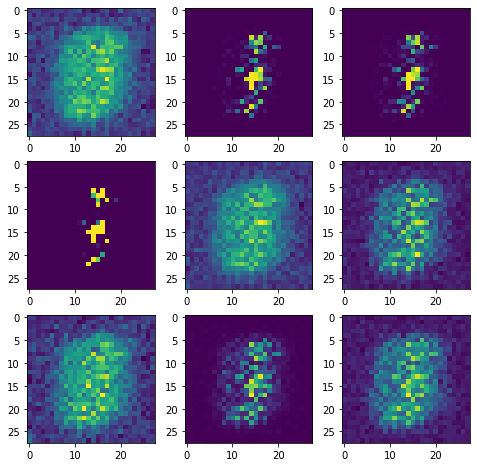

-------------------- Epoche 2 von 20 --------------------
Epoche 0 DiscLoss 0.22658990323543549 GenLoss 2.9006242752075195
Epoche 100 DiscLoss 0.35253018140792847 GenLoss 1.3273810148239136
Epoche 200 DiscLoss 0.5901923179626465 GenLoss 0.9022700786590576
Epoche 300 DiscLoss 0.4495074450969696 GenLoss 0.9497197866439819
Epoche 400 DiscLoss 0.4496396780014038 GenLoss 0.9718130826950073


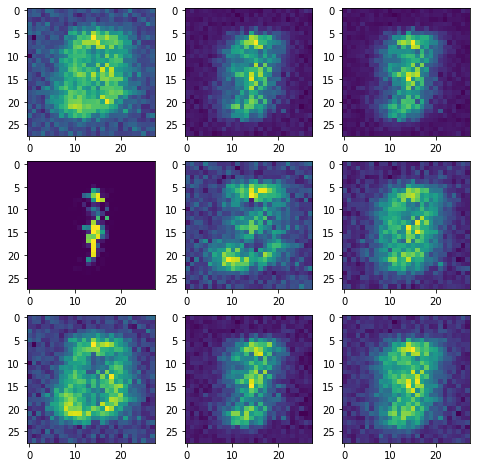

-------------------- Epoche 3 von 20 --------------------
Epoche 0 DiscLoss 0.3825482726097107 GenLoss 1.265777349472046
Epoche 100 DiscLoss 0.24622765183448792 GenLoss 1.9989540576934814
Epoche 200 DiscLoss 0.30942797660827637 GenLoss 1.5057649612426758
Epoche 300 DiscLoss 0.3034880757331848 GenLoss 1.9238184690475464
Epoche 400 DiscLoss 0.31520503759384155 GenLoss 1.507673740386963


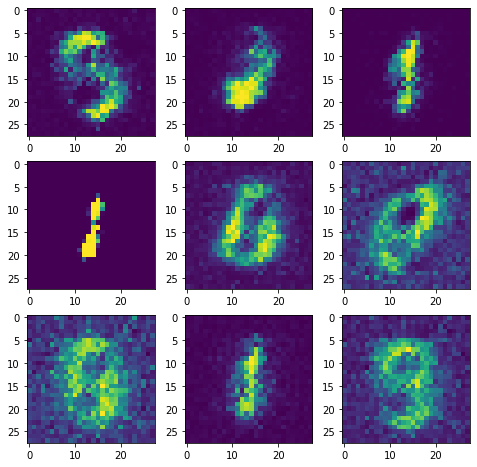

-------------------- Epoche 4 von 20 --------------------
Epoche 0 DiscLoss 0.31236881017684937 GenLoss 2.2011871337890625
Epoche 100 DiscLoss 0.39868730306625366 GenLoss 1.454546332359314
Epoche 200 DiscLoss 0.3603718876838684 GenLoss 1.5474706888198853
Epoche 300 DiscLoss 0.4477381408214569 GenLoss 1.2107785940170288
Epoche 400 DiscLoss 0.3993681073188782 GenLoss 1.6455901861190796


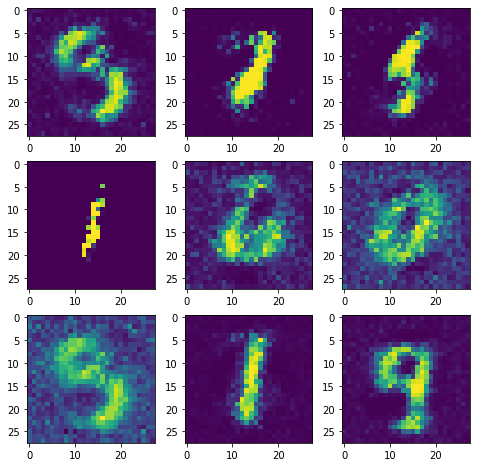

-------------------- Epoche 5 von 20 --------------------
Epoche 0 DiscLoss 0.35682183504104614 GenLoss 1.7778968811035156
Epoche 100 DiscLoss 0.44750428199768066 GenLoss 1.5611753463745117
Epoche 200 DiscLoss 0.37302112579345703 GenLoss 1.9522088766098022
Epoche 300 DiscLoss 0.4098169207572937 GenLoss 1.5167696475982666
Epoche 400 DiscLoss 0.3827669620513916 GenLoss 1.5911314487457275


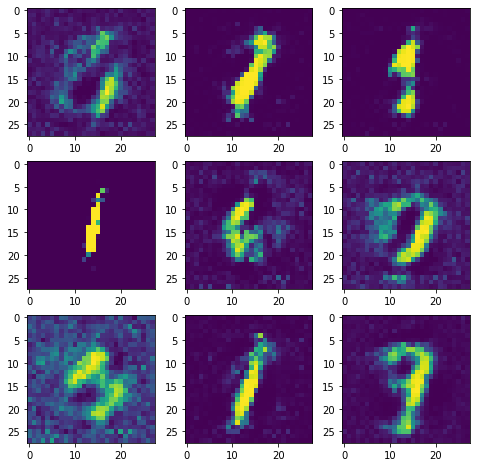

-------------------- Epoche 6 von 20 --------------------
Epoche 0 DiscLoss 0.3917462229728699 GenLoss 1.6909321546554565
Epoche 100 DiscLoss 0.5259437561035156 GenLoss 1.2015154361724854
Epoche 200 DiscLoss 0.41085511445999146 GenLoss 1.0593242645263672
Epoche 300 DiscLoss 0.4310406446456909 GenLoss 1.2208459377288818
Epoche 400 DiscLoss 0.40159422159194946 GenLoss 1.1978322267532349


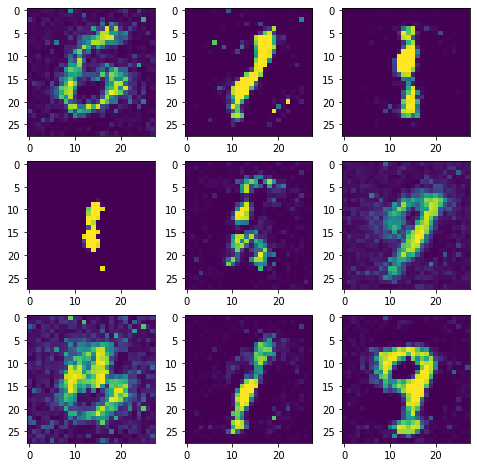

-------------------- Epoche 7 von 20 --------------------
Epoche 0 DiscLoss 0.4625418782234192 GenLoss 1.2312967777252197
Epoche 100 DiscLoss 0.4742344617843628 GenLoss 1.3631457090377808
Epoche 200 DiscLoss 0.5368408560752869 GenLoss 1.29349946975708
Epoche 300 DiscLoss 0.5336249470710754 GenLoss 1.1394798755645752
Epoche 400 DiscLoss 0.5169179439544678 GenLoss 1.1084439754486084


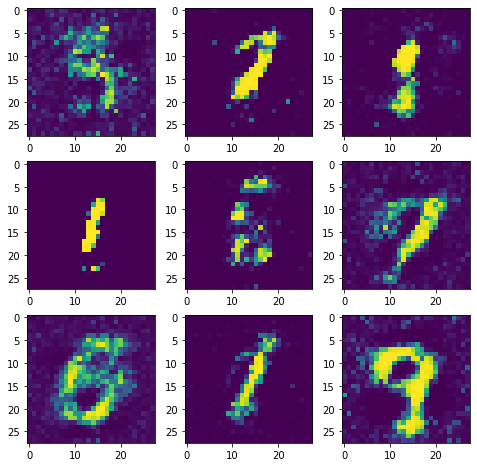

-------------------- Epoche 8 von 20 --------------------
Epoche 0 DiscLoss 0.6143205761909485 GenLoss 1.1461316347122192
Epoche 100 DiscLoss 0.45804402232170105 GenLoss 1.1820363998413086
Epoche 200 DiscLoss 0.554958701133728 GenLoss 1.1555918455123901
Epoche 300 DiscLoss 0.45857930183410645 GenLoss 1.2352077960968018
Epoche 400 DiscLoss 0.621212363243103 GenLoss 1.1278048753738403


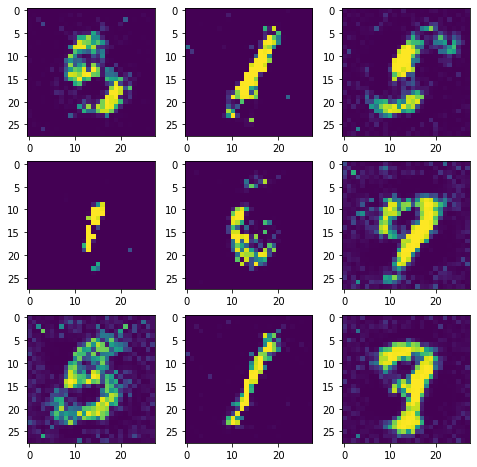

-------------------- Epoche 9 von 20 --------------------
Epoche 0 DiscLoss 0.594019889831543 GenLoss 1.2943248748779297
Epoche 100 DiscLoss 0.487656831741333 GenLoss 1.7611998319625854
Epoche 200 DiscLoss 0.5576039552688599 GenLoss 0.9484809041023254
Epoche 300 DiscLoss 0.5613710284233093 GenLoss 0.9379918575286865
Epoche 400 DiscLoss 0.5368094444274902 GenLoss 0.9700987339019775


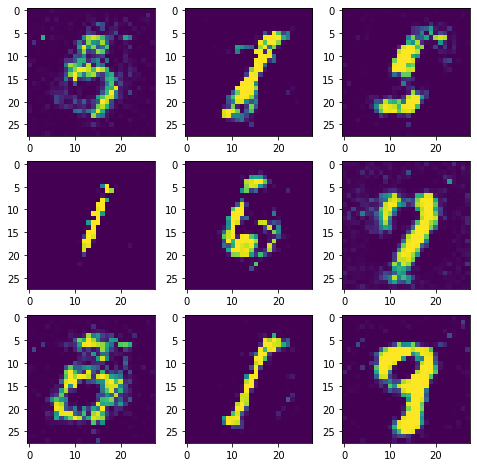

-------------------- Epoche 10 von 20 --------------------
Epoche 0 DiscLoss 0.5929366946220398 GenLoss 0.9194333553314209
Epoche 100 DiscLoss 0.6433289051055908 GenLoss 1.1596319675445557
Epoche 200 DiscLoss 0.5990467667579651 GenLoss 0.9027602672576904
Epoche 300 DiscLoss 0.5528785586357117 GenLoss 0.888656735420227
Epoche 400 DiscLoss 0.6711453795433044 GenLoss 0.8776975870132446


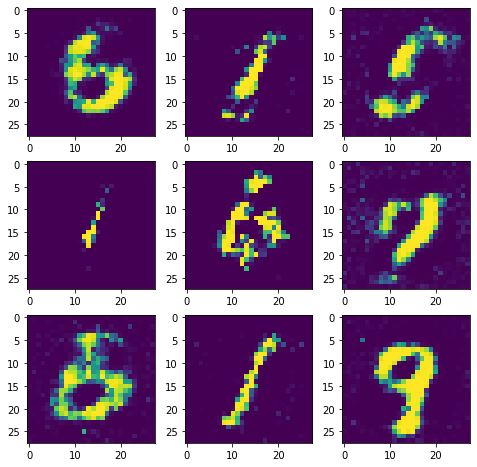

-------------------- Epoche 11 von 20 --------------------
Epoche 0 DiscLoss 0.5628474950790405 GenLoss 1.177262306213379
Epoche 100 DiscLoss 0.5955102443695068 GenLoss 0.9664009213447571
Epoche 200 DiscLoss 0.5490245819091797 GenLoss 0.9331503510475159
Epoche 300 DiscLoss 0.6084779500961304 GenLoss 0.882709264755249
Epoche 400 DiscLoss 0.5610462427139282 GenLoss 0.8607221841812134


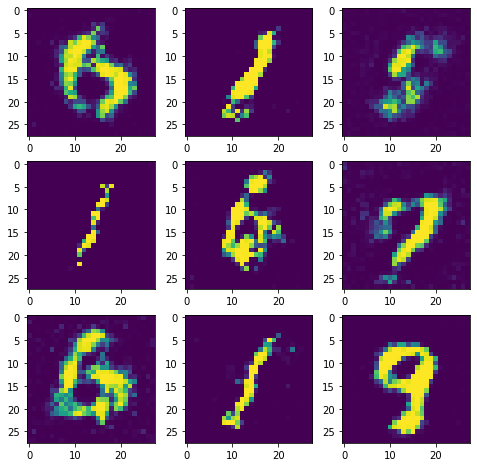

-------------------- Epoche 12 von 20 --------------------
Epoche 0 DiscLoss 0.5991138219833374 GenLoss 0.791652262210846
Epoche 100 DiscLoss 0.6103457808494568 GenLoss 0.9892334342002869
Epoche 200 DiscLoss 0.6280480027198792 GenLoss 1.1561006307601929
Epoche 300 DiscLoss 0.601811408996582 GenLoss 0.960727334022522
Epoche 400 DiscLoss 0.5734775066375732 GenLoss 0.8725452423095703


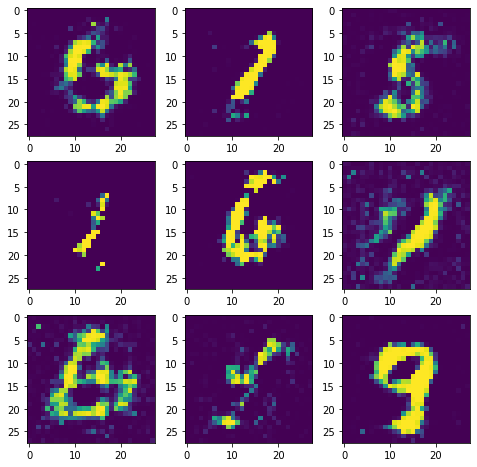

-------------------- Epoche 13 von 20 --------------------
Epoche 0 DiscLoss 0.6313528418540955 GenLoss 0.8241038918495178
Epoche 100 DiscLoss 0.5875375270843506 GenLoss 0.9025683999061584
Epoche 200 DiscLoss 0.6010875701904297 GenLoss 0.8619047403335571
Epoche 300 DiscLoss 0.5348109602928162 GenLoss 1.31526780128479
Epoche 400 DiscLoss 0.6372439861297607 GenLoss 0.9651755690574646


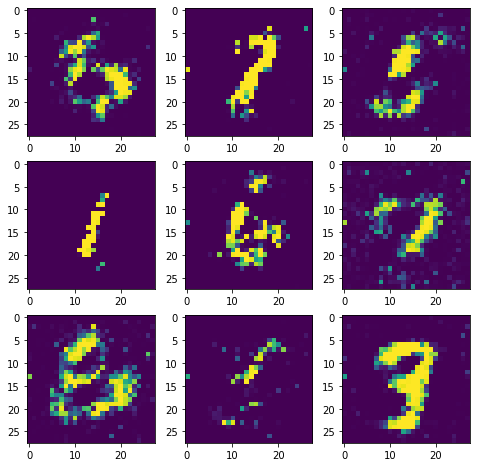

-------------------- Epoche 14 von 20 --------------------
Epoche 0 DiscLoss 0.6748192310333252 GenLoss 0.962542712688446
Epoche 100 DiscLoss 0.464255154132843 GenLoss 1.8162695169448853
Epoche 200 DiscLoss 0.595260739326477 GenLoss 0.9852930903434753
Epoche 300 DiscLoss 0.4707954525947571 GenLoss 0.9244715571403503
Epoche 400 DiscLoss 0.6061365604400635 GenLoss 0.868395209312439


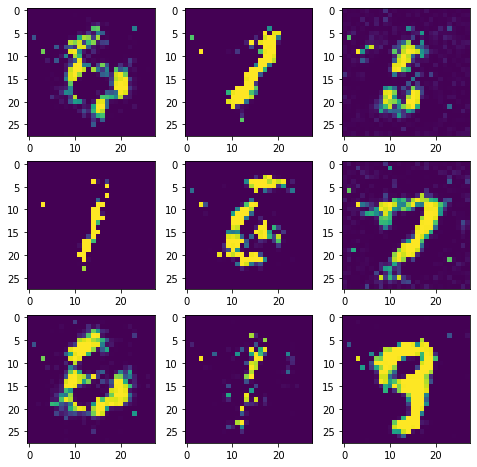

-------------------- Epoche 15 von 20 --------------------
Epoche 0 DiscLoss 0.6408291459083557 GenLoss 0.9392467141151428
Epoche 100 DiscLoss 0.5171446204185486 GenLoss 1.2099395990371704
Epoche 200 DiscLoss 0.5116003155708313 GenLoss 0.9573825001716614
Epoche 300 DiscLoss 0.5468312501907349 GenLoss 0.9416905641555786
Epoche 400 DiscLoss 0.577028751373291 GenLoss 0.894504189491272


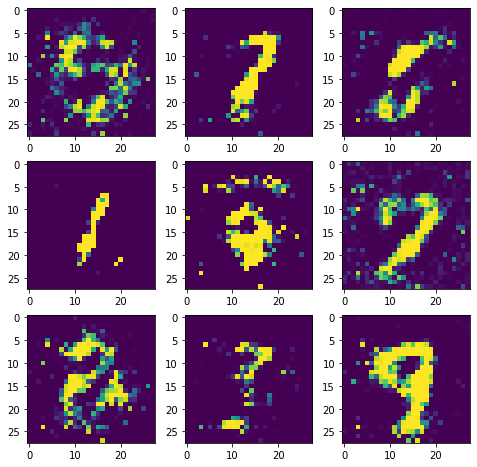

-------------------- Epoche 16 von 20 --------------------
Epoche 0 DiscLoss 0.6377477645874023 GenLoss 1.086709976196289
Epoche 100 DiscLoss 0.680194616317749 GenLoss 0.9248249530792236
Epoche 200 DiscLoss 0.6093987822532654 GenLoss 0.8471219539642334
Epoche 300 DiscLoss 0.42236077785491943 GenLoss 0.965238094329834
Epoche 400 DiscLoss 0.6470891833305359 GenLoss 0.9120786786079407


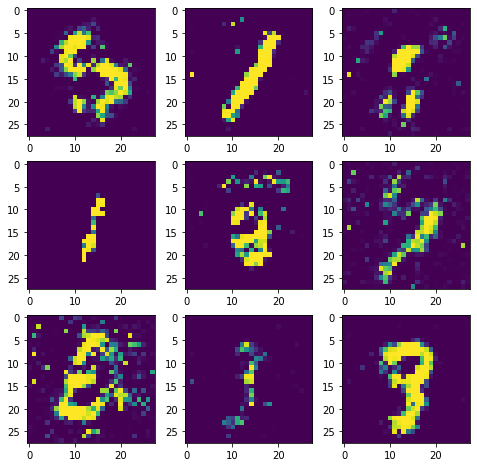

-------------------- Epoche 17 von 20 --------------------
Epoche 0 DiscLoss 0.5162752866744995 GenLoss 1.3115921020507812
Epoche 100 DiscLoss 0.6699992418289185 GenLoss 0.9092371463775635
Epoche 200 DiscLoss 0.6091037392616272 GenLoss 1.56593656539917
Epoche 300 DiscLoss 0.586544930934906 GenLoss 0.862708330154419
Epoche 400 DiscLoss 0.6390601396560669 GenLoss 0.8707997798919678


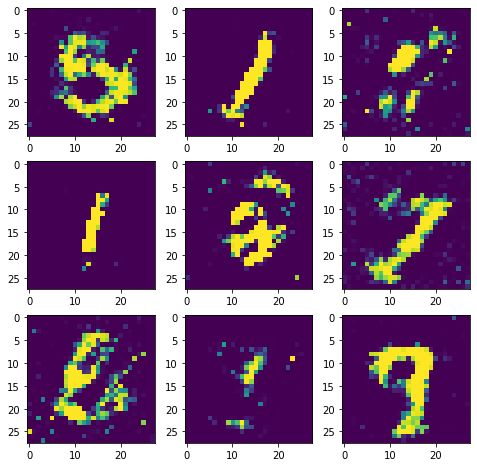

-------------------- Epoche 18 von 20 --------------------
Epoche 0 DiscLoss 0.6121896505355835 GenLoss 0.8625390529632568
Epoche 100 DiscLoss 0.6293230652809143 GenLoss 1.0724377632141113
Epoche 200 DiscLoss 0.6370198726654053 GenLoss 0.9647320508956909
Epoche 300 DiscLoss 0.5760552883148193 GenLoss 0.9034063816070557
Epoche 400 DiscLoss 0.6076956987380981 GenLoss 0.9130973815917969


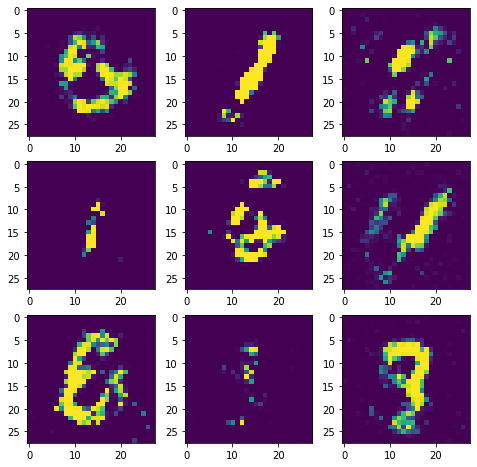

-------------------- Epoche 19 von 20 --------------------
Epoche 0 DiscLoss 0.6912699937820435 GenLoss 1.1551437377929688
Epoche 100 DiscLoss 0.6673945188522339 GenLoss 0.8038816452026367
Epoche 200 DiscLoss 0.6281545162200928 GenLoss 0.822123646736145
Epoche 300 DiscLoss 0.6286406517028809 GenLoss 0.8403780460357666
Epoche 400 DiscLoss 0.6749296188354492 GenLoss 0.9341403841972351


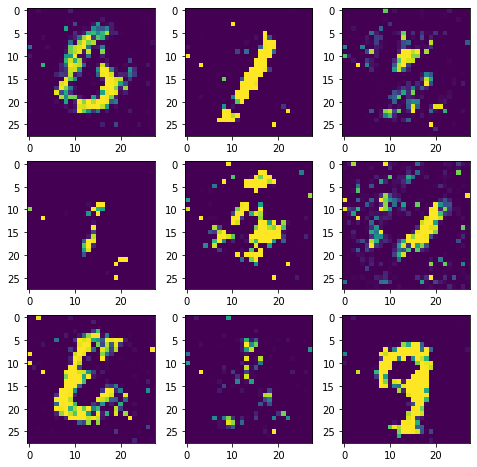

-------------------- Epoche 20 von 20 --------------------
Epoche 0 DiscLoss 0.6597267389297485 GenLoss 0.8425121307373047
Epoche 100 DiscLoss 0.6200531721115112 GenLoss 0.8657093644142151
Epoche 200 DiscLoss 0.5824716091156006 GenLoss 0.7723476886749268
Epoche 300 DiscLoss 0.4676662087440491 GenLoss 1.8662488460540771
Epoche 400 DiscLoss 0.4496806263923645 GenLoss 1.6134004592895508


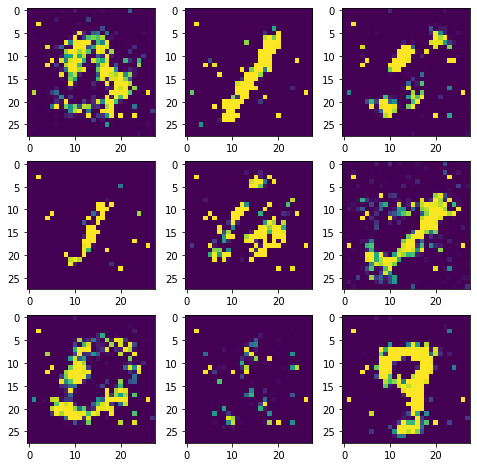

In [7]:
# Hyperparameter
n_epochs = 20
batch_size = 128
# Lernrate (sollte an Batch-Size angepasst werden: Größere Batch-Size -> kleinere Lernrate)
base_lr = 1e-3
disc_fac = 1 # eventuell muss der Diskriminator "langsamer" trainiert werden -> setze auf zwischen 0 und 1
lr_gen = base_lr
lr_disc = base_lr*disc_fac # eventuell muss der Diskriminator "langsamer" trainiert werden

# Initialisiere Generator und Diskriminator
gen = Generator().to(device)
disc = Discriminator().to(device)
# Initialisiere Optimierer
optim_gen = torch.optim.Adam(gen.parameters(), lr=lr_gen)
optim_disc = torch.optim.Adam(disc.parameters(), lr=lr_disc)
# Dataloader, Loss-Funktion und Test-Daten (zum Plotten nach jeder Epoche)
dataloader = DataLoader(MNIST, batch_size=batch_size, shuffle=True)
loss_func = nn.BCELoss()
test_input = torch.randn([9, 128]).to(device)

for epoch in range(n_epochs):
    print("-"*20,"Epoche",epoch+1,"von",n_epochs,"-"*20)
    schritt_counter = 0
    for n_batch, (batch,_) in enumerate(dataloader):
        # Setze Gradienten auf 0
        optim_disc.zero_grad()
        optim_gen.zero_grad()

        # Diskriminator-Training
        batch = batch.to(device).flatten(start_dim=-2, end_dim=-1)
        generated_data = gen(torch.randn([batch_size, 128]).to(device)).unsqueeze(1) # Generator-Output
        input = torch.cat((batch, generated_data)) # Hänge Daten aneinander
        labels = torch.cat((torch.ones([len(batch),1]), torch.zeros([batch_size,1]))).to(device) # Generiere Label
        output = disc(input).squeeze(dim=1)
        loss_disc = loss_func(output, labels) # Loss
        loss_disc.backward() # Generiere Gradienten
        optim_disc.step() # Update Diskriminator

        # Generator-Training
        generated_data = gen(torch.randn([batch_size, 128]).to(device)).unsqueeze(1) # Generator-Output
        output = disc(generated_data)
        loss_gen = loss_func(output.squeeze(), torch.ones(batch_size).to(device))
        loss_gen.backward() # Generiere Gradienten
        optim_gen.step() # Update Generator

        if n_batch%100==0:
            print("Epoche", n_batch, "DiscLoss", loss_disc.item(), "GenLoss", loss_gen.item())
        schritt_counter+=1
        #print(loss)

    generated_data = gen(test_input)
    plt.figure(figsize=[8,8])
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(generated_data[i].reshape([28,28]).detach().cpu().numpy())
    plt.show()
